# Neuronales Netz zum erstellen eines Deepfakes
***

Dieses Dokument ermöglicht Dir, ein Deepfake-Video zu erstellen, wären Du über die Funktion und den Aufbau des dazu verwendeten künstlichen Neuronalen Netzes lernst.  

***
##### *Das folgende Dokument setzt sich aus folgenden Schritten zusammen:*
1. Einlesen und Aufbereiten von den Daten zum Trainieren
    - Extrahieren von Gesichter aus einem Video
    - Einlesen dieser Daten
2. Initialisieren des künstlichen Neuronalen Netzes
    - Definieren der Struktur des Encoder und Decoder
    - Kombinieren des Encoder und Decoder zu den Autoencodern
    - Kompilieren der Modelle mit einem Optimizer
3. Trainieren
    - Festlegen von Checkpoints für das Trainieren
    - Eigentliches Trainieren des Netzes
4. Fälschen eines neuen Videos
---

## Einlesen und Aufbereiten von den Daten zum Trainieren
***
Um dem künstlichen Neuronalen Netz beizubringen Gesichter zu erkennen und zu erstellen, werden zahlreiche Bilder von Gesichtern benötigt. Im Fall von Deepfakes ist Bildmaterial von zwei Personen nötig. Einfachheitshalber wird als Input Videomaterial verwendet.

### Extrahieren von Gesichter aus einem Video
In den Variablen *PFAD_A* und *PFAD_B* werden die Pfade zu den Videos gespeichert, die dazu verwendet werden Bilder von zwei Personen zu erxtrahieren. Es werden mit der Hilfe der Klasse `Gesichterextrahierer`, die in einer externen Datei definiert wurde, die Gesichter aus den Videos extrahiert. Die Bilder werden in einem Verzeichnis gespeichert.

In [ ]:
import Gesichterextrahierer as GE

PFAD_A = './daten/videomaterial/Biden.mp4'
PFAD_B = './daten/videomaterial/Trump.mp4'
PFAD_KASKADE = './daten/cascades/haarcascade_frontalface_default.xml'

g = GE.Gesichterextrahierer(PFAD_KASKADE)
g.lade(PFAD_A)
g.extrahiereUndValidiereGesichter(
    referenzbild=cv2.imread("./Biden.png"),
    max_anzahl_gesichter=2000,
    ordner_ausgabe='./daten/lernen/A'
)
g.lade(PFAD_B)
g.extrahiereUndValidiereGesichter(
    referenzbild=cv2.imread("./Trump.png"),
    max_anzahl_gesichter=2000,
    ordner_ausgabe='./daten/lernen/B'
)

del PFAD_A, PFAD_B, PFAD_KASKADE, g, GE

### Einlesen der Bilddateien
Dass die Bilder als Datei gespeichert wurden, erspart uns beim nächsten Mal den vorherigen Schritt. Die Dateien müssen nun allerdings wieder ins Programm geladen werden.

> `erstelleDatensatz(pfad: str) -> list[list]`
>
> Lädt alle Bilder in dem übergebenen Verzeichnis in zwei Datensätze und gibt diese als Liste zurück. Jeder Pixelwert wird durch 255 geteilt, um die Werte auf den Bereich zwischen 0 und 1 zu projektieren. Dies stellt sicher, dass die Werte des künstlischen Neuronale Netzes (KNN), wenn das Bild übergeben wird, nicht zu groß werden. Die Bilder werden in zwei Datensätze umgewandelt, zu 75% zum Trainieren des KNN und zu 25% zum Prüfen und Bewerten der Leistung des Netzes.

> `teileListe(liste: list, verteilung: float) -> list[list]`
>
> Teilt die übergebene Liste in zwei Listen und gibt diese zurück. Die erste zurückgegebene Liste hat ein Länge von _n_-% der übergebenen Liste, wobei _n_ als Kommazahl zwischen 1 und 0 mit `verteilung` übergeben wird.

> `verzerren(bild: list, staerke: int) -> 'Bild'`
>
> Gibt eine verzerrte Version des übergebene Bild, als würde man das Bild von weiter rechts betrachten. Die `stärke` (eine ganze Z)

**Um zu prüfen, ob dies geklappt hat, wird hier ein beispielhaftes Bild dargestellt.**

In [1]:
import numpy as np
import cv2
import os

def erstelleDatensatz(pfad: str, anzahl: int) -> list:
    bilder = []
    for wurzel, ordner, dateien in os.walk(pfad):
        dateien = [e for e in dateien if e.split(".")[-1].lower() in ['png', 'jpg', 'jpeg']]
        dateien = dateien[:int(anzahl/4)]
        for datei in dateien:
            bild = cv2.imread(os.path.join(wurzel, datei))
            bild = bild.astype('float32')
            bild /= 255.0
            
            for e in [bild, np.fliplr(bild), verzerren(bild, 10), np.fliplr(verzerren(bild, 10))]:
                bilder.append(e)
                if len(bilder) >= anzahl: break
                
    np.random.shuffle(bilder)
    bilder_train, bilder_test = teileListe(bilder, 0.75)
    bilder_train, bilder_test = np.array(bilder_train), np.array(bilder_test)
    print('%d Bilder aus %s geladen.' % (len(bilder), pfad))
    return [bilder_train, bilder_test]

def teileListe(liste: list, verteilung: float) -> list:
    x = int(len(liste)*verteilung)
    return [liste[:x], liste[x:]]

def verzerren(bild: list, staerke: int) -> list:
    hoehe, breite = bild.shape[0:2]
    punkte_von = np.float32([[0, 0], [0, hoehe], [breite, 0], [breite, hoehe]])
    punkte_nach = np.float32([[0, staerke], [0, hoehe-staerke], [breite, 0], [breite, hoehe]])
    matrix = cv2.getPerspectiveTransform(punkte_von, punkte_nach)
    bild_verzerrt = cv2.warpPerspective(bild, matrix, (breite, hoehe))
    bild_verzerrt = bild_verzerrt[staerke:hoehe-staerke, staerke:breite-staerke]
    return cv2.resize(bild_verzerrt, (breite, hoehe))

datensatz_gesichter_A_train, datensatz_gesichter_A_test = erstelleDatensatz('daten/lernen/Gesichter/A', 5000)
NAME_AUTOENCODER_A = 'Biden'

datensatz_gesichter_B_train, datensatz_gesichter_B_test = erstelleDatensatz('daten/lernen/Gesichter/B', 5000)
NAME_AUTOENCODER_B = 'Trump'

5000 Bilder aus daten/lernen/Gesichter/A geladen.
5000 Bilder aus daten/lernen/Gesichter/B geladen.


### Um zu prüfen, ob die Bilder korrekt geladen wurden

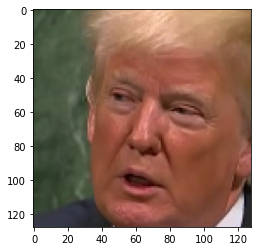

In [2]:
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(cv2.cvtColor(datensatz_gesichter_B_test[1], cv2.COLOR_BGR2RGB))

del imshow

## Initialisieren des Neuronalen Netzes
***
Nun wird das künstlichen Neuronale Netz initialisiert. Dazu wird die Struktur des Netzes definiert und das Modell anschließend kompiliert.

### Definieren der Struktur des Encoder und Decoder

Der `NAME` wird als Idenetifikation und zum Abspeichern verwendet.

> `logSummary(string: str)`
>
> Die Funktion, die später dazu verwendet wird die Zusammenfassung des Netzes abzuspeichern.

> `gibEncoder()`
>
> Definiere hier deinen Encoder. Das Modell wird von der Funktion zurückgegeben.

> `gibDecoder()`
>
> Definiere hier deinen Decoder. Das Modell wird von der Funktion zurückgegeben.

In [3]:
import tensorflow as tf

IMG_SHAPE = (128, 128, 3)
NAME = "Dense_Pres"

def logSummary(string: str):
    with open(f"./daten/modelle/{NAME}/modell.info", "a") as datei:
        datei.write(string + "\n")

def gibEncoder():
    encoder = tf.keras.Sequential(name='encoder')
    encoder.add(tf.keras.layers.Reshape( (49152,), input_shape=( IMG_SHAPE ) ))
    encoder.add(tf.keras.layers.Dense( 500 ))
    encoder.add(tf.keras.layers.Dense( 200 ))
    
    encoder.summary(print_fn=logSummary)
    print(encoder.summary())
    return encoder

def gibDecoder():
    decoder = tf.keras.Sequential(name='decoder')
    decoder.add(tf.keras.layers.Dense(500, input_shape=(200,)))
    decoder.add(tf.keras.layers.Dense( 49152 ))
    decoder.add(tf.keras.layers.Reshape( IMG_SHAPE ))
    
    decoder.summary(print_fn=logSummary)
    print(decoder.summary())
    return decoder

### Kombinieren des Encoder und Decoder zu den Autoencodern

In [4]:
def gibAutoencoder(name):
    x = tf.keras.layers.Input( shape=IMG_SHAPE, name='input_layer' )
    encoder, decoder = gibEncoder(), gibDecoder()
    autoencoder = tf.keras.Model(x, decoder(encoder(x)), name=name)
    
    print(autoencoder.summary())
    return autoencoder

### Kompilieren der Modelle mit einem Optimizer

> `gibKompiliertenAutoencoder(name)`
>
> Kombiniert den Encoder und Decoder zu einem Autoencoder und gibt diesen als kompiliertes Modell zurück.

In [5]:
OPTIMIZER_FUNKTION = tf.keras.optimizers.Adam(learning_rate=1e-5)
LOSS_FUNKTION = tf.keras.losses.MeanSquaredError()

def gibKompiliertenAutoencoder(name):
    autoencoder = gibAutoencoder(name)
    autoencoder.compile(optimizer=OPTIMIZER_FUNKTION, loss=LOSS_FUNKTION)
    
    return autoencoder

Falls bereits ein Modell mit dem zuvor definierten Namen exestiert, wird dieses geladen. Ist das nicht der Fall, wird ein neues Modell erstellt. Anschließend wird zur Übersicht der Fehler-Wert der Modelle ermittelt.

In [6]:
try:
    autoencoder_A = tf.keras.models.load_model(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/")
    autoencoder_B = tf.keras.models.load_model(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/")
    print("Modelle von der Festplatte geladen.\n")
except Exception as e:
    print(e)
    try:
        os.mkdir(f"./daten/modelle/{NAME}/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/Bilder/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/Bilder/")
    except FileExistsError:
        pass
    autoencoder_A = gibKompiliertenAutoencoder(name="autoencoder_A")
    autoencoder_B = gibKompiliertenAutoencoder(name="autoencoder_B")
    
loss = autoencoder_A.evaluate(datensatz_gesichter_A_test[:32], datensatz_gesichter_A_test[:32])
print(f"Aktueller Loss von A ({NAME_AUTOENCODER_A}): {loss}")

loss = autoencoder_B.evaluate(datensatz_gesichter_B_test[:32], datensatz_gesichter_B_test[:32])
print(f"Aktueller Loss von B ({NAME_AUTOENCODER_B}): {loss}")

2021-12-21 14:54:53.581644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:54:53.625449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:54:53.625767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:54:53.626281: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

SavedModel file does not exist at: ./daten/modelle/Dense_Pres/Trump//{saved_model.pbtxt|saved_model.pb}
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               24576500  
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
Total params: 24,676,700
Trainable params: 24,676,700
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               100500    
_____________________________________________________

2021-12-21 14:54:54.619808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 0s 260ms/step - loss: 0.3187
Aktueller Loss von A (Biden): 0.3186674416065216
1/1 [==============================] - 0s 47ms/step - loss: 0.2146
Aktueller Loss von B (Trump): 0.21455346047878265


## Trainieren
***

### Festlegen von Checkpoints für das Trainieren

Hier werden Callbacks definiert, die später Trainingsfunktion übergeben werden. Die Callbacks enthalten Anweisungen, die während dem Training ausgeführt werden. Hierzu zählt zum Beispiel das regelmäßige Speichern des Fortschritts.

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
import LoggingCallback as lc


autoencoder_A_logging_callback = lc.LoggingCallback(
    pfad_modell=f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/",
    bild_A=datensatz_gesichter_A_test[1],
    bild_B=datensatz_gesichter_B_test[1]
)

autoencoder_B_logging_callback = lc.LoggingCallback(
    pfad_modell=f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/",
    bild_A=datensatz_gesichter_A_test[1],
    bild_B=datensatz_gesichter_B_test[1]
)

autoencoder_A_checkpoint_callback = ModelCheckpoint(
    f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/",
    monitor='val_loss',
    save_best_only=True
)

autoencoder_B_checkpoint_callback = ModelCheckpoint(
    f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/",
    monitor='val_loss',
    save_best_only=True
)

### Eigentliches Trainieren des Netzes

Nun wird das Modell trainiert. In der dritten Zeile kann die gewünschte Dauer des Trainings definiert werden. Die beiden Autoencoder werden abwechselnd für jeweils ein Epoche trainiert, dann wird Encoder zwischen den Modellen getauscht. Dies soll sicherstellen, dass die beiden Autoencoder die geichen Muster in den Bilder erkennen und somit schlussendlich Bilder fälschen.
Die batch_size bestimmt wie viel Bilder gleichzeitig trainiert werden. Ist dieser Wert zu hoch kommt es schnell zu einem OOM (Out of Memory, also dem Volllaufen des Arbeitsspeichers) Error.

In [7]:
import time, gc

ZEITPUNKT_ENDE = time.time() + int(8*60*60)

while time.time() < ZEITPUNKT_ENDE:
    print("!- Noch für ~{:.1f}h beschäftigt.".format(( ZEITPUNKT_ENDE-time.time() )/3600) )
    
    autoencoder_A.fit(
                      datensatz_gesichter_A_train,
                      datensatz_gesichter_A_train,
                      epochs=1,
                      batch_size=16,
                      shuffle=True,
                      validation_data=(datensatz_gesichter_A_test, datensatz_gesichter_A_test),
                      callbacks=[autoencoder_A_checkpoint_callback, autoencoder_A_logging_callback]
                     )
    autoencoder_B.layers[1] = autoencoder_A.get_layer('encoder')
    gc.collect()
    
    autoencoder_B.fit(
                      datensatz_gesichter_B_train,
                      datensatz_gesichter_B_train,
                      epochs=1,
                      batch_size=16,
                      shuffle=True,
                      validation_data=(datensatz_gesichter_B_test, datensatz_gesichter_B_test),
                      callbacks=[autoencoder_B_checkpoint_callback, autoencoder_B_logging_callback]
                     )
    autoencoder_A.layers[1] = autoencoder_B.get_layer('encoder')
    gc.collect()

!- Noch für ~8.0h beschäftigt.


NameError: name 'autoencoder_A_checkpoint_callback' is not defined

### Fälschen eines neuen Videos

Nun geht es daran das Gefälschte Video zu erstellen.

---
Zunächst hat man hier die Möglichkeit eine Vorschau der Leistungsfähigkeit des Modells zu erhalten.

Wechsle zwischen `autoencoder_A` und `autoencoder_B`, um das Modell zur jeweils anderen Person zu ändern.

Wechsle zwischen `datensatz_gesichter_A_test` und `datensatz_gesichter_B_test`, um die Person, deren Gesichter dem Modell übergeben werden zu ändern.

Ändere den Index nach `datensatz_gesichter_*_test`, um ein anderes Gesicht der Person auszuwählen.

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline

img = cv2.cvtColor(autoencoder_A.predict(datensatz_gesichter_A_test[1].reshape(1, 128, 128, 3))[0], cv2.COLOR_BGR2RGB)
img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
imshow(img)

Und abschließend kann hier ein Video gefälscht werden. Ändere auch hier `autoencoder_*`, um das Modell zu wechseln.

In [ ]:
import Gesichterextrahierer as GE

PFAD_KASKADE = './daten/cascades/haarcascade_frontalface_default.xml'

def fake(bild):
    bild = bild.astype('float32')
    bild /= 255.0
    erg = autoencoder_B.predict(bild.reshape(1, 128, 128, 3))[0]
    erg = cv2.normalize(erg,  None, 0, 255, cv2.NORM_MINMAX)
    return erg

g = GE.Gesichterextrahierer(PFAD_KASKADE)
g.lade('./Joe_Biden_nah.mp4')
g.fuerGesichterMache(fake, 10000, True)